.

<div style="text-align: center; font-size: 25px; font-weight: bold;"> A FIZETÉSI HAJLANDÓSSÁG ELŐREJELZÉSÉNEK MŰVÉSZETE </div>
<div style="text-align: center; font-size: 10px;"> --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- </div>
<div style="text-align: center; font-size: 20px; font-weight: bold;"> Egy prediktív RFC modell építésének bemutatása: adatoktól az előrejelzések értékeléséig </div>



.

## A "Send a tree" alkalmazás bemutatása
- #### Mester Tomi "Junior Data Scientist Academy" kurzusához kitalált online alkalmazás és a hozzá tartozó adatbázis

<img src="sendatree.jpg" width="1200" height="900">

---

## Az RFC modell bemutatása dióhéjban

<img src="rfc.jpg" width="1200" height="800">

---

## A modell építéshez szükséges importok és az adatok betöltése

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# adatbetöltés most hogy már nincs szükség az automatizációra

registrations = pd.read_csv('all_reg.csv', sep = ' ', names = ['file_name', 'reg_date', 'reg_time', 'user_id', 'event', 'birth_year', 'device', 'country', 'source'])
free_tree = pd.read_csv('all_free_tree.csv', sep = ' ', names = ['file_name', 'send_date', 'user_id', 'event'])
super_tree = pd.read_csv('all_super_tree.csv', sep = ' ', names = ['file_name', 'send_date', 'user_id', 'event'])


### Adatbetöltés amikor még naponta frissülő adatokkal dolgoztam
<img src="dataload.jpg" width="1200" height="800">

---

## Mire prediktáljunk? 

In [3]:
# Mikor küldte az első fizetős fát a user? Azaz mikor küldte a második super_tree-jét?

pt_send_date = super_tree.groupby('user_id')[['user_id', 'send_date']].nth(1)
pt_send_date = pt_send_date.rename(columns={'send_date': 'pt_send_date'})
pt_send_date


,user_id,pt_send_date
1,1000080,2022-10-14
4,1000037,2022-10-14
6,1000100,2022-10-14
9,1000097,2022-10-14
14,1000040,2022-10-14
...,...,...
78992,1126776,2023-05-21
78997,1126547,2023-05-21
78999,1127736,2023-05-21
79008,1127419,2023-05-21


In [4]:
# A regisztrációhoz képest mikor volt a userek első paid_tree küldése?

tmp = registrations.merge(pt_send_date, how='outer', on = 'user_id')
tmp = tmp[['reg_date','user_id','pt_send_date']]

import datetime
tmp['reg_date'] = pd.to_datetime(tmp['reg_date'])
tmp['pt_send_date'] = pd.to_datetime(tmp['pt_send_date'])

for i in range(0,15):
    filtered_rows = tmp[(tmp.reg_date <= tmp.pt_send_date) & (tmp.pt_send_date <= (tmp.reg_date + pd.Timedelta(days=i)))]
    row_count = filtered_rows.shape[0]
    print(str(i) + ' nap elteltével a paid_tree-t küldők száma: ' + str(row_count))

0 nap elteltével a paid_tree-t küldők száma: 11746
1 nap elteltével a paid_tree-t küldők száma: 17548
2 nap elteltével a paid_tree-t küldők száma: 17794
3 nap elteltével a paid_tree-t küldők száma: 17895
4 nap elteltével a paid_tree-t küldők száma: 17956
5 nap elteltével a paid_tree-t küldők száma: 17995
6 nap elteltével a paid_tree-t küldők száma: 18018
7 nap elteltével a paid_tree-t küldők száma: 18042
8 nap elteltével a paid_tree-t küldők száma: 18048
9 nap elteltével a paid_tree-t küldők száma: 18051
10 nap elteltével a paid_tree-t küldők száma: 18052
11 nap elteltével a paid_tree-t küldők száma: 18052
12 nap elteltével a paid_tree-t küldők száma: 18052
13 nap elteltével a paid_tree-t küldők száma: 18052
14 nap elteltével a paid_tree-t küldők száma: 18052


### Prediktáljunk arra, hogy a regisztrációt követő 3 napon belül küld-e fizetős fát a user 


---

## Célváltozó létrehozása
    >> vizsgáljuk meg, melyik userek küldtek a regisztrációt követő első 3 napon belül fizetős fát

In [5]:
# Regisztráció napjától számítva 3 napon belül küldött-e fizetős fát a user?

tmp = registrations.merge(pt_send_date, on = 'user_id')

tmp['reg_date'] = pd.to_datetime(tmp['reg_date'])
tmp['pt_send_date'] = pd.to_datetime(tmp['pt_send_date'])

pt_sending = tmp[(tmp.reg_date <= tmp.pt_send_date) & (tmp.pt_send_date <= (tmp.reg_date + pd.Timedelta(days=3)))]
pt_sending = pt_sending[['user_id','pt_send_date']]
pt_sending = pt_sending.rename(columns={'pt_send_date': 'pt_sending'})

pt_sending['pt_sending']=1
pt_sending

,user_id,pt_sending
0,1000010,1
1,1000011,1
2,1000022,1
3,1000026,1
4,1000037,1
...,...,...
18047,1128805,1
18048,1128826,1
18049,1128836,1
18050,1128841,1


---

## Származtatott változók létrehozása
    >> a meglévő adatokból létrehozunk 2 új változót: 
            ft_sendings: hány free_tree-t küldött a user a regisztrációt követő első 3 napban
            first_st_send: elküldte-e az első super_tree-jét a regisztrációt követő első 3 napban

In [6]:
tmp = free_tree.groupby(['user_id','send_date']).count()[['event']].reset_index()
tmp = tmp.rename(columns={'send_date': 'ft_send_date'})

tmp['ft_send_date'] = pd.to_datetime(tmp['ft_send_date'])

tmp2 = tmp.groupby('user_id')[['ft_send_date']].first().reset_index()
tmp2 = tmp2.rename(columns={'ft_send_date': 'first_ft_send'})

tmp3 = tmp.merge(tmp2, how='left', on='user_id')

tmp3['first_ft_send'] = pd.to_datetime(tmp3['first_ft_send'])

tmp3 = tmp3[tmp3.ft_send_date <= (tmp3.first_ft_send + pd.Timedelta(days=3))]
tmp3 = tmp3.groupby(['user_id'])['event'].sum().reset_index()

ft_sendings = tmp3.rename(columns={'event': 'ft_sendings'})
ft_sendings

,user_id,ft_sendings
0,1000001,5
1,1000002,4
2,1000003,14
3,1000005,5
4,1000006,4
...,...,...
99489,1128847,13
99490,1128848,1
99491,1128850,2
99492,1128853,4


In [7]:
tmp = super_tree.groupby(['user_id'])['send_date'].first().reset_index()
tmp = tmp.rename(columns={'send_date': 'first_st_send'})

tmp = registrations.merge(tmp, how='left', on='user_id')
tmp = tmp[['reg_date','user_id','first_st_send']]

tmp['reg_date'] = pd.to_datetime(tmp['reg_date'])
tmp['first_st_send'] = pd.to_datetime(tmp['first_st_send'])

tmp = tmp[tmp.first_st_send <= (tmp.reg_date + pd.Timedelta(days=3))]

tmp = tmp[['user_id','first_st_send']]
tmp['first_st_send'] = 1

first_st_send = tmp
first_st_send

,user_id,first_st_send
6,1000007,1
9,1000010,1
10,1000011,1
12,1000013,1
18,1000019,1
...,...,...
128846,1128847,1
128850,1128851,1
128851,1128852,1
128852,1128853,1


---

## Train (known) és Test (unknown) halmaz definiálása

    >> train (known) = összes adat - az utolsó hét adatai
    >> test (unknown) = utolsó hét adatai

In [8]:
df = registrations[['user_id','reg_date','birth_year','device','country','source']]
df = df.merge(ft_sendings, how='inner', on='user_id')
df = df.merge(st_sending, how='left', on='user_id').fillna(0)
df = df.merge(pt_sending, how='left', on='user_id').fillna(0)

df['first_st_send'] = df['first_st_send'].astype(int)
df['pt_sending'] = df['pt_sending'].astype(int)

df

,user_id,reg_date,birth_year,device,country,source,ft_sendings,first_st_send,pt_sending
0,1000001,2022-10-14,1983,android,sweden,invite_a_friend,5,0,0
1,1000002,2022-10-14,1986,ios,united_states,invite_a_friend,4,0,0
2,1000003,2022-10-14,1989,error,sweden,invite_a_friend,14,0,0
3,1000005,2022-10-14,1986,ios,united_states,invite_a_friend,5,0,0
4,1000006,2022-10-14,1983,android,sweden,invite_a_friend,4,0,0
...,...,...,...,...,...,...,...,...,...
99489,1128847,2023-05-21,1987,error,united_states,invite_a_friend,13,1,0
99490,1128848,2023-05-21,1987,error,united_states,paid,1,0,0
99491,1128850,2023-05-21,1986,error,brazil,invite_a_friend,2,0,0
99492,1128853,2023-05-21,1991,android,brazil,invite_a_friend,4,1,0


In [9]:
last_reg_date = pd.to_datetime('2023-05-21')

df['reg_date'] = pd.to_datetime(df['reg_date'])

known = df[df.reg_date <= (last_reg_date - datetime.timedelta(days=7))]
unknown = df[df.reg_date > (last_reg_date - datetime.timedelta(days=7))]

In [10]:
known

,user_id,reg_date,birth_year,device,country,source,ft_sendings,first_st_send,pt_sending
0,1000001,2022-10-14,1983,android,sweden,invite_a_friend,5,0,0
1,1000002,2022-10-14,1986,ios,united_states,invite_a_friend,4,0,0
2,1000003,2022-10-14,1989,error,sweden,invite_a_friend,14,0,0
3,1000005,2022-10-14,1986,ios,united_states,invite_a_friend,5,0,0
4,1000006,2022-10-14,1983,android,sweden,invite_a_friend,4,0,0
...,...,...,...,...,...,...,...,...,...
90106,1116725,2023-05-14,1987,ios,united_states,invite_a_friend,7,0,0
90107,1116726,2023-05-14,1996,android,united_states,invite_a_friend,6,0,0
90108,1116728,2023-05-14,1985,android,sweden,article,2,0,0
90109,1116729,2023-05-14,1986,error,united_states,invite_a_friend,18,0,0


In [11]:
unknown

,user_id,reg_date,birth_year,device,country,source,ft_sendings,first_st_send,pt_sending
90111,1116731,2023-05-15,1987,android,brazil,article,2,0,0
90112,1116732,2023-05-15,1987,android,brazil,paid,1,0,0
90113,1116733,2023-05-15,1986,error,brazil,paid,1,0,0
90114,1116735,2023-05-15,1993,android,united_states,paid,1,0,0
90115,1116736,2023-05-15,1995,android,united_states,invite_a_friend,4,1,1
...,...,...,...,...,...,...,...,...,...
99489,1128847,2023-05-21,1987,error,united_states,invite_a_friend,13,1,0
99490,1128848,2023-05-21,1987,error,united_states,paid,1,0,0
99491,1128850,2023-05-21,1986,error,brazil,invite_a_friend,2,0,0
99492,1128853,2023-05-21,1991,android,brazil,invite_a_friend,4,1,0


---

## Adatok feltérképezése manuálisan


In [12]:
known.groupby(['birth_year','pt_sending'])[['user_id']].count()

user_id
birth_year pt_sending         
1980       0               226
1981       0               822
1982       0              1965
1983       0              3447
1984       0              5356
1985       0              6902
1986       0              8392
1987       0              9548
           1               174
1988       0              9419
           1               768
1989       0              8880
           1               859
1990       0              6384
           1              2772
1991       0              4289
           1              3300
1992       0              3335
           1              2904
1993       0              2040
           1              2409
1994       0              1719
           1              1265
1995       0              1206
           1               517
1996       0               667
           1               183
1997       0               252
           1                37
1998       0                73
           1                 1

In [13]:
known.groupby(['country','pt_sending'])[['user_id']].count()

user_id
country       pt_sending         
brazil        0             11168
              1              5673
germany       0              3695
philippines   0              8184
sweden        0             14011
              1                70
united_states 0             37864
              1              9446

In [14]:
known.groupby(['source','pt_sending'])[['user_id']].count()

user_id
source          pt_sending         
article         0             10625
                1               303
google          0             12803
                1              2123
invite_a_friend 0             46569
                1             12763
paid            0              4925

In [15]:
known.groupby(['ft_sendings','pt_sending'])[['user_id']].count()

user_id
ft_sendings pt_sending         
1           0             13207
            1              1312
2           0              9819
            1              1158
3           0              7081
...                         ...
32          1                12
33          0                10
            1                 5
34          0                 4
            1                 2

[68 rows x 1 columns]

In [16]:
known.groupby(['first_st_send','pt_sending'])[['user_id']].count()

user_id
first_st_send pt_sending         
0             0             62058
1             0             12864
              1             15189

---

## Adatok előkészítése a RFC-hez

In [17]:
known

,user_id,reg_date,birth_year,device,country,source,ft_sendings,first_st_send,pt_sending
0,1000001,2022-10-14,1983,android,sweden,invite_a_friend,5,0,0
1,1000002,2022-10-14,1986,ios,united_states,invite_a_friend,4,0,0
2,1000003,2022-10-14,1989,error,sweden,invite_a_friend,14,0,0
3,1000005,2022-10-14,1986,ios,united_states,invite_a_friend,5,0,0
4,1000006,2022-10-14,1983,android,sweden,invite_a_friend,4,0,0
...,...,...,...,...,...,...,...,...,...
90106,1116725,2023-05-14,1987,ios,united_states,invite_a_friend,7,0,0
90107,1116726,2023-05-14,1996,android,united_states,invite_a_friend,6,0,0
90108,1116728,2023-05-14,1985,android,sweden,article,2,0,0
90109,1116729,2023-05-14,1986,error,united_states,invite_a_friend,18,0,0


In [18]:
birth_year_decoder = {1980: 0, 1981: 1, 1982: 2, 1983: 3, 1984: 4, 1985: 5, 1986: 6, 1987: 7, 1988: 8, 1989: 9,
                      1990: 10, 1991: 11, 1992: 12, 1993: 13, 1994: 14, 1995: 15, 1996: 16, 1997: 17, 1998: 18}

country_decoder = {'united_states': 0, 'sweden': 1, 'germany': 2, 
                   'brazil': 3, 'philippines': 4}

source_decoder = {'article': 0, 'google': 1, 
                   'invite_a_friend': 2, 'paid': 3}

device_decoder = {'android': 0, 'ios': 1, 'error': 2}

known.loc[:, 'birth_year'] = known['birth_year'].map(birth_year_decoder)
known.loc[:, 'country'] = known['country'].map(country_decoder)
known.loc[:, 'source'] = known['source'].map(source_decoder)
known.loc[:, 'device'] = known['device'].map(device_decoder)

known

,user_id,reg_date,birth_year,device,country,source,ft_sendings,first_st_send,pt_sending
0,1000001,2022-10-14,3,0,1,2,5,0,0
1,1000002,2022-10-14,6,1,0,2,4,0,0
2,1000003,2022-10-14,9,2,1,2,14,0,0
3,1000005,2022-10-14,6,1,0,2,5,0,0
4,1000006,2022-10-14,3,0,1,2,4,0,0
...,...,...,...,...,...,...,...,...,...
90106,1116725,2023-05-14,7,1,0,2,7,0,0
90107,1116726,2023-05-14,16,0,0,2,6,0,0
90108,1116728,2023-05-14,5,0,1,0,2,0,0
90109,1116729,2023-05-14,6,2,0,2,18,0,0


In [ ]:
unknown

In [19]:
birth_year_decoder = {1980: 0, 1981: 1, 1982: 2, 1983: 3, 1984: 4, 1985: 5, 1986: 6, 1987: 7, 1988: 8, 1989: 9,
                      1990: 10, 1991: 11, 1992: 12, 1993: 13, 1994: 14, 1995: 15, 1996: 16, 1997: 17, 1998: 18}

country_decoder = {'united_states': 0, 'sweden': 1, 'germany': 2, 
                   'brazil': 3, 'philippines': 4}

source_decoder = {'article': 0, 'google': 1, 
                   'invite_a_friend': 2, 'paid': 3}

device_decoder = {'android': 0, 'ios': 1, 'error': 2}

unknown.loc[:, 'birth_year'] = unknown['birth_year'].map(birth_year_decoder)
unknown.loc[:, 'country'] = unknown['country'].map(country_decoder)
unknown.loc[:, 'source'] = unknown['source'].map(source_decoder)
unknown.loc[:, 'device'] = unknown['device'].map(device_decoder)

unknown

,user_id,reg_date,birth_year,device,country,source,ft_sendings,first_st_send,pt_sending
90111,1116731,2023-05-15,7,0,3,0,2,0,0
90112,1116732,2023-05-15,7,0,3,3,1,0,0
90113,1116733,2023-05-15,6,2,3,3,1,0,0
90114,1116735,2023-05-15,13,0,0,3,1,0,0
90115,1116736,2023-05-15,15,0,0,2,4,1,1
...,...,...,...,...,...,...,...,...,...
99489,1128847,2023-05-21,7,2,0,2,13,1,0
99490,1128848,2023-05-21,7,2,0,3,1,0,0
99491,1128850,2023-05-21,6,2,3,2,2,0,0
99492,1128853,2023-05-21,11,0,3,2,4,1,0


In [20]:
known.to_csv('known.csv', index=False)
unknown.to_csv('unknown.csv', index=False)

---

# Prediktálás a train (known) halmazon

In [35]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

In [22]:
known = pd.read_csv('known.csv')
known

,user_id,reg_date,birth_year,device,country,source,ft_sendings,first_st_send,pt_sending
0,1000001,2022-10-14,3,0,1,2,5,0,0
1,1000002,2022-10-14,6,1,0,2,4,0,0
2,1000003,2022-10-14,9,2,1,2,14,0,0
3,1000005,2022-10-14,6,1,0,2,5,0,0
4,1000006,2022-10-14,3,0,1,2,4,0,0
...,...,...,...,...,...,...,...,...,...
90106,1116725,2023-05-14,7,1,0,2,7,0,0
90107,1116726,2023-05-14,16,0,0,2,6,0,0
90108,1116728,2023-05-14,5,0,1,0,2,0,0
90109,1116729,2023-05-14,6,2,0,2,18,0,0


In [23]:
X_train = known[['birth_year', 'device', 'country', 'source', 'ft_sendings', 'first_st_send']]
y_train = known['pt_sending']

In [24]:
model = RandomForestClassifier(n_estimators = 50, n_jobs=8)
model = model.fit(X_train, y_train)

In [25]:
model

RandomForestClassifier(n_estimators=50, n_jobs=8)

In [27]:
sample_user = [6, 2, 1, 2, 11, 0]
model.predict([sample_user])

/home/kriszta/.local/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0])

In [28]:
# warning: a modellt egy df-re illesztettük, és aztán a predikcióhoz egy NumPy tömbön akarjuk használni

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')


In [29]:
for index, row in known.head(50).iterrows():
    print(model.predict([[row['birth_year'], row['device'], row['country'], row['source'], row['ft_sendings'], row['first_st_send']]]))

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]


In [30]:
predicted_labels = []
for index, row in known.iterrows():
    predicted_label = model.predict([[row['birth_year'], row['device'], row['country'], row['source'], row['ft_sendings'], row['first_st_send']]])[0]
    predicted_labels.append(predicted_label)

known['predicted'] = predicted_labels

### Érdekesség: ahhoz, hogy emberi időben lefusson a predikció fel kellett skáláznom a szerveremet
<img src="server.jpg" width="1200" height="800">

---

# Ellenőrzés

In [31]:
known_check = known[['pt_sending','predicted']]
known_check

,pt_sending,predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
90106,0,0
90107,0,0
90108,0,0
90109,0,0


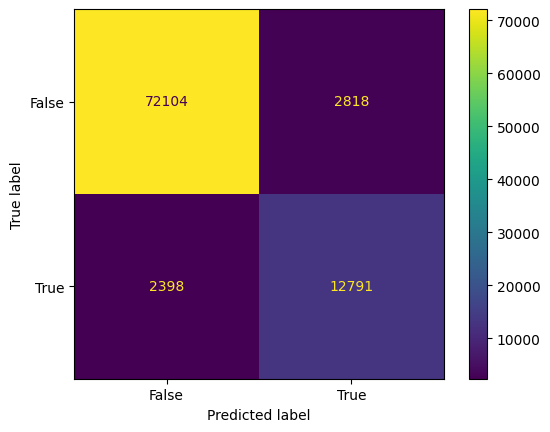

In [36]:
from sklearn import metrics
actual = known_check['pt_sending']
predicted = known_check['predicted']

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

---

## A modell teljesítményének értékelése a train halmazon:


In [37]:
print(classification_report(known['pt_sending'], known['predicted']))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     74922
           1       0.82      0.84      0.83     15189

    accuracy                           0.94     90111
   macro avg       0.89      0.90      0.90     90111
weighted avg       0.94      0.94      0.94     90111



---

## A modell által használt változók jelentősségének lekérdezése

In [38]:
pd.DataFrame({'features': X_train.columns, 
              'importance': model.feature_importances_}).sort_values(['importance'], ascending=False)

,features,importance
5,first_st_send,0.508193
0,birth_year,0.271053
2,country,0.100586
4,ft_sendings,0.048509
3,source,0.048433
1,device,0.023226


---

## Prediktálás az unknown datasetben

In [39]:
unknown = pd.read_csv('unknown.csv')

In [40]:
X_test = unknown[['birth_year', 'device', 'country', 'source', 'ft_sendings', 'first_st_send']]
y_test = unknown['pt_sending']

In [41]:
model_test = RandomForestClassifier(n_estimators = 50, n_jobs=8)
model_test = model_test.fit(X_test, y_test)

In [42]:
predicted_labels = []
for index, row in unknown.iterrows():
    predicted_label = model_test.predict([[row['birth_year'], row['device'], row['country'], row['source'], row['ft_sendings'], row['first_st_send']]])[0]
    predicted_labels.append(predicted_label)

unknown['predicted'] = predicted_labels

---

## Ellenőrzés

In [43]:
unknown_check = unknown[['pt_sending','predicted']]
unknown_check

,pt_sending,predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1
...,...,...
9378,0,0
9379,0,0
9380,0,0
9381,0,1


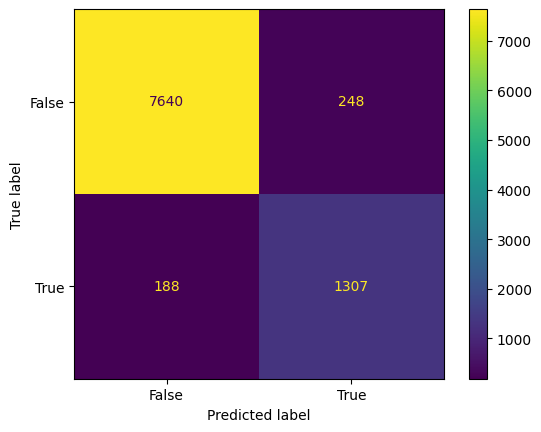

In [44]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = unknown_check['pt_sending']
predicted = unknown_check['predicted']

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

---

## A modell teljesítményének értékelése a test halmazon:


In [45]:
print("Klasszifikációs Riport - RFC modell teljesítményéről\n")
print(classification_report(unknown['pt_sending'], unknown['predicted']))

Klasszifikációs Riport - RFC modell teljesítményéről

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      7888
           1       0.84      0.87      0.86      1495

    accuracy                           0.95      9383
   macro avg       0.91      0.92      0.91      9383
weighted avg       0.95      0.95      0.95      9383



---

## A modell prediktáló képességének értékelése összességében


<div>
    <h3>1) Accuracy:</h3>
    <ul>
        <li>Mind a tanítási, mind a teszt halmazon magas a pontosság, 0.94 és 0.95 >> A modell általánosan jól teljesít, nem tanult túl, képes általánosítani.</li>
    </ul>
    <h3>2) Precision:</h3>
    <ul>
        <li>A '0' osztály esetében magas a precision, mindkét halmazon közel 0.97, ami azt jelzi, hogy a modell nagyon jól képes azonosítani a valódi negatív eseteket >> akiket nem fizetős usernek jósol, azok valóban nem is válnak fizetőssé.</li>
        <li>Az '1' osztály esetében a precision valamivel alacsonyabb, de még mindig elfogadható, körülbelül 0.82 és 0.84, ami azt jelzi, hogy a modell némi hibát követ el a fals pozitív predikciókban >> a modell túlbecsülheti azoknak a felhasználóknak a számát, akik fizetős szolgáltatást vesznek igénybe. Ez a tényező különösen fontos lehet üzleti döntések vagy stratégiai tervezés során, így azon még érdemes lenne dolgozni, hogy csökkentsük a tévesen pozitívnak jósolt esetek számát.</li>
    </ul>
    <h3>3) Recall:</h3>
    <ul>
        <li>A visszahívás szintén magas a '0' osztály esetében (0.96 és 0.97), ami megintcsak azt jelenti, hogy a modell jól képes felismerni a valódi negatív esetek nagy részét.</li>
        <li>Az '1' osztály esetében a visszahívás kissé alacsonyabb, de még mindig jó, körülbelül 0.85 és 0.88, ami azt jelzi, hogy a modell képes felismerni a valódi pozitív esetek jelentős részét.</li>
    </ul>
    <h3>4) F1-Score:</h3>
    <ul>
        <li>Ez az érték szintén magas mindkét osztály esetében, ami azt mutatja, hogy a modell kiegyensúlyozottan teljesít a precision és a recall szempontjából.</li>
    </ul>
    <h3>5) Support:</h3>
    <ul>
        <li>A support azt mutatja, hogy az egyes osztályok hány példányát tartalmazza a teszt halmaz. A '0' osztály jelentősen nagyobb mintát mutat, ami arra utalhat, hogy az adathalmaz egyenlőtlenül van elosztva az osztályok között. Ez a modell teljesítményének értékelésekor fontos tényező lehet, mert ha az egyik osztály sokkal több mintát tartalmaz, a modell teljesítménye torzulhat az erősebb reprezentáció irányába.</li>
    </ul>
</div>

### Összességében elmondható a modell teljesítménye jó, de lehetne javítani rajta. 

    - a hiperparaméterek finomhangolása vagy  
    - az adathalmaz egyenlőtlenségeinek kiegyensúlyozása segíthet javítani a modell teljesítményét

---

## Egy kis érdekesség a végére... DT vs RFC

In [46]:
from sklearn.tree import DecisionTreeClassifier

X_train = known[['birth_year', 'device', 'country', 'source', 'ft_sendings', 'first_st_send']]
y_train = known['pt_sending']
X_test = unknown[['birth_year', 'device', 'country', 'source', 'ft_sendings', 'first_st_send']]
y_test = unknown['pt_sending']

dt_base = DecisionTreeClassifier()   
dt_base.fit(X_train, y_train)

DecisionTreeClassifier()

In [47]:
base_train_pred_pro = dt_base.predict_proba(X_train)    # így egy valószínűséget (probability) ad vissza a modell
base_train_pred_cat = dt_base.predict(X_train)          # így egy cimkét ad vissza a modell

base_test_pred_pro = dt_base.predict_proba(X_test)      
base_test_pred_cat = dt_base.predict(X_test)            

print('teszt predikció - valószínűség:', base_test_pred_pro[0:5])
print('teszt predikció - címke:', base_test_pred_cat[0:5])


teszt predikció - valószínűség: [[1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [0.3 0.7]]
teszt predikció - címke: [0 0 0 0 1]


In [49]:
from sklearn.metrics import classification_report

print("Klasszifikációs Riport - 1 döntési fa teljesítményéről\n")
print(classification_report(y_test, base_test_pred_cat))
print("-----------------------------------------------------------------------")
print("Klasszifikációs Riport - RFC modell teljesítményéről\n")
print(classification_report(unknown['pt_sending'], unknown['predicted']))

Klasszifikációs Riport - 1 döntési fa teljesítményéről

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      7888
           1       0.78      0.84      0.81      1495

    accuracy                           0.94      9383
   macro avg       0.88      0.90      0.89      9383
weighted avg       0.94      0.94      0.94      9383

-----------------------------------------------------------------------
Klasszifikációs Riport - RFC modell teljesítményéről

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      7888
           1       0.84      0.87      0.86      1495

    accuracy                           0.95      9383
   macro avg       0.91      0.92      0.91      9383
weighted avg       0.95      0.95      0.95      9383

